<a href="https://colab.research.google.com/github/widyamelia26/Facial-Emotion-Recognition/blob/main/Salinan_dari_Emosi_EfficientNetb3_(25%2C13_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%bash

# Check if the dataset already exists
if test -e "emotion-detection-fer.zip"; then
    rm -rf emotion-detection-fer.zip ./train ./test
    kaggle datasets download -d ananthu017/emotion-detection-fer
    unzip emotion-detection-fer.zip
else
    kaggle datasets download -d ananthu017/emotion-detection-fer
    unzip emotion-detection-fer.zip
fi

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0

Archive:  emotion-detection-fer.zip
  inflating: test/angry/im0.png      
  inflating: test/angry/im1.png      
  inflating: test/angry/im10.png     
  inflating: test/angry/im100.png    
  inflating: test/angry/im101.png    
  inflating: test/angry/im102.png    
  inflating: test/angry/im103.png    
  inflating: test/angry/im104.png    
  inflating: test/angry/im105.png    
  inflating: test/angry/im106.png    
  inflating: test/angry/im107.png    
  inflating: test/angry/im108.png    
  inflating: test/angry/im109.png    
  inflating: test/angry/im11.png     
  inflating: test/angry/im110.png    
  inflating: test/angry/im111.png    
  inflating: test/angry/im112.png    
  inflating: test/angry/im113.png    
  inflating: test/angry/im114.png    
  inflating: test/angry/im115.png    
  inflating: test/angry/im116.png    
  inflating: test/angry/im117.png    
  inflating: test/angry/im118

100%|██████████| 65.2M/65.2M [00:03<00:00, 17.6MB/s]


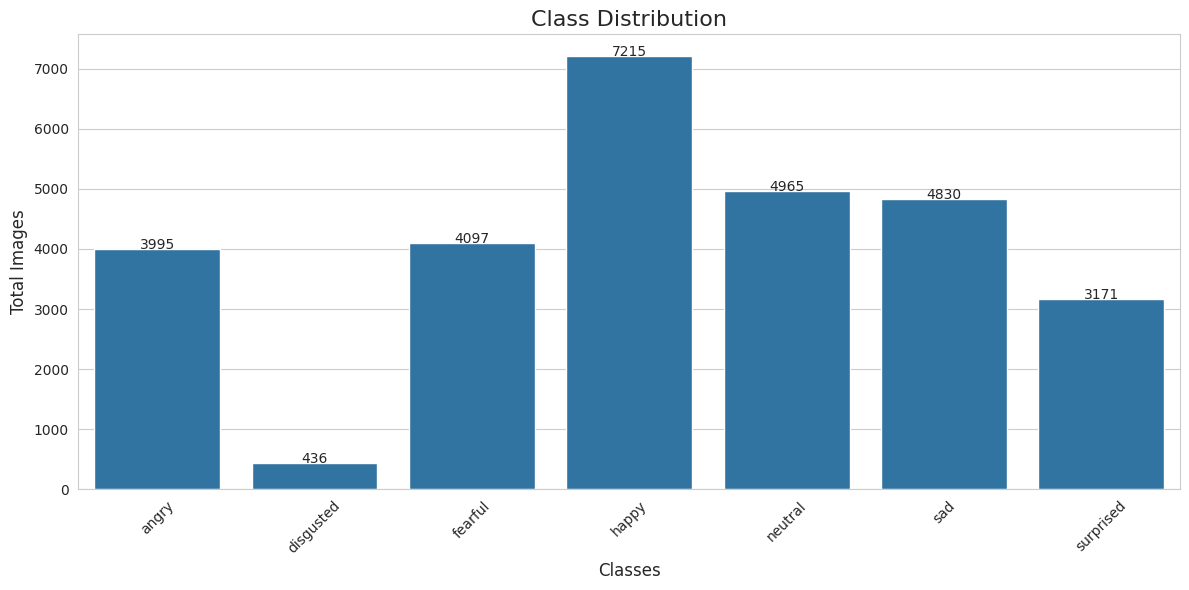

In [2]:
import glob

import matplotlib.pyplot as plt
import seaborn as sns


train_path = "/content/train"
test_path = "/content/test"
class_names = ["angry", "disgusted", "fearful", "happy", "neutral", "sad", "surprised"]
class_distribution = {}

# Put image paths to dictionary using class names as keys.
for class_name in class_names:
    class_distribution[class_name] = len(glob.glob(f"{train_path}/{class_name}/*"))

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(x=list(class_distribution.keys()), y=list(class_distribution.values()))

plt.title("Class Distribution", fontsize=16)
plt.xlabel("Classes", fontsize=12)
plt.ylabel("Total Images", fontsize=12)
plt.xticks(rotation=45)

# Add value labels of each bar.
for index, value in enumerate(class_distribution.values()):
    plt.text(index, value, str(value), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

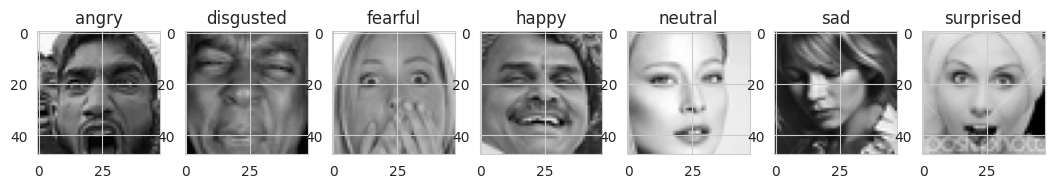

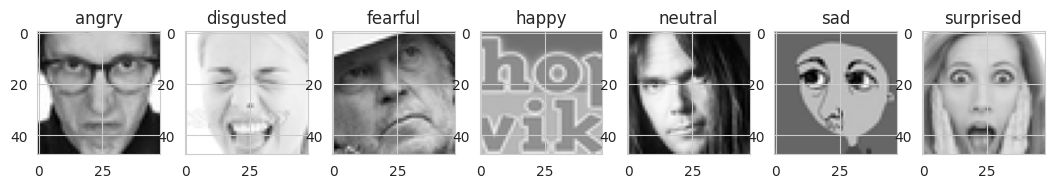

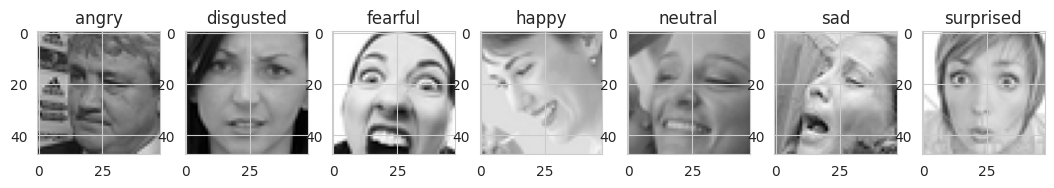

In [3]:
import cv2
import numpy as np


def plot_sample_images():
    fig, axis = plt.subplots(1, 7, figsize=[13, 15])

    for index, (class_name, count) in enumerate(class_distribution.items()):
        # Randomly choose images to plot.
        random_index = np.random.randint(0, count)
        img_read = cv2.imread(
            glob.glob(f"{train_path}/{class_name}/*")[random_index]
        )

        axis[index].imshow(img_read)
        axis[index].set_title(class_name)

# Plot several samples of each class.
for i in range(0, 3):
    plot_sample_images()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data generator for traning and validation.
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect',  # Changed to reflect
    validation_split=0.2,
    brightness_range=[0.7,1.3],
    zoom_range=0.2,
    shear_range=0.2,
    channel_shift_range=0.2
)

validation_data_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # 20% of images to be used for validation.
)

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=16,
    class_mode="categorical",
    subset="training",
)

validation_generator = validation_data_generator.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=16,
    class_mode="categorical",
    subset="validation",
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.


In [5]:
# Data generator for evaluation.
test_data_generator = ImageDataGenerator(rescale=1./255)
test_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=16,
    class_mode="categorical",
    shuffle = False  # Keep this False for confusion matrix.
)

Found 7178 images belonging to 7 classes.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization, Activation, Flatten, Add, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import numpy as np

# Constants
INPUT_SHAPE = (48, 48, 3)
NUM_CLASSES = 7
BATCH_SIZE = 16  # Smaller batch size for better generalization
INITIAL_LR = 5e-5  # Lower initial learning rate

def residual_block(x, filters, kernel_size=3):
    """Custom residual block for better feature extraction"""
    shortcut = x

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.01))(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters, kernel_size, padding='same', kernel_regularizer=l2(0.01))(x)
    x = LayerNormalization()(x)

    # If dimensions don't match, adjust shortcut
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_advanced_model():
    # Load base model
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_SHAPE
    )

    # Unfreeze more layers for better feature extraction
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    inputs = base_model.input
    x = base_model.output

    # Add custom layers after EfficientNetB3
    x = GlobalAveragePooling2D()(x)
    x = LayerNormalization()(x)

    # First dense block with residual connection
    shortcut = x
    x = Dense(512, kernel_regularizer=l2(0.01))(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, kernel_regularizer=l2(0.01))(x)
    x = LayerNormalization()(x)
    if shortcut.shape[-1] != 512:
        shortcut = Dense(512)(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    # Second dense block
    x = Dense(256, kernel_regularizer=l2(0.01))(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.4)(x)

    # Third dense block
    x = Dense(128, kernel_regularizer=l2(0.01))(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    # Output layer with weighted loss
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1434/1436 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1778 - loss: 19.8103
Epoch 1: val_accuracy improved from -inf to 0.23620, saving model to best_model_efficientnetb3_high_accuracy.keras
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 166s 77ms/step - accuracy: 0.1778 - loss: 19.8093 - val_accuracy: 0.2362 - val_loss: 18.3127 - learning_rate: 1.0000e-05
Epoch 2/100
1435/1436 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1975 - loss: 17.7604
Epoch 2: val_accuracy improved from 0.23620 to 0.25170, saving model to best_model_efficientnetb3_high_accuracy.keras
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 71s 49ms/step - accuracy: 0.1975 - loss: 17.7593 - val_accuracy: 0.2517 - val_loss: 15.2456 - learning_rate: 2.0000e-05
Epoch 3/100
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1993 - loss: 14.2541
Epoch 3: val_accuracy did not improve from 0.25170
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 68s 47ms/step - accuracy: 0.1993 - loss: 14.2534 - val_accuracy: 0.2512 - val_loss: 10.8712 - learning_rate: 3.0000e-05
E

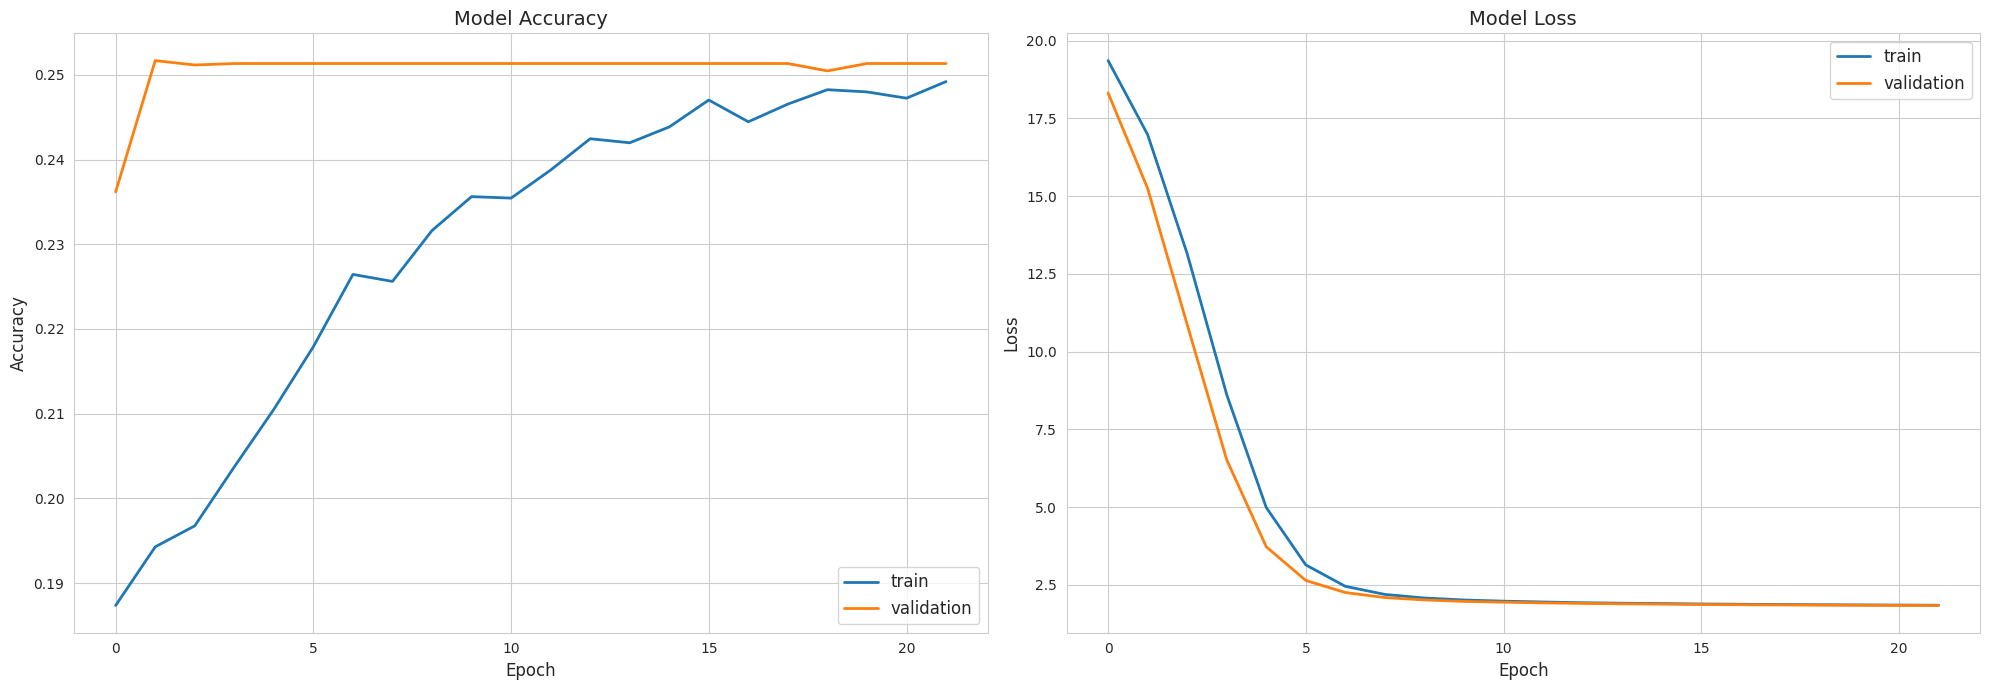

449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.2219 - loss: 15.3254

Test Accuracy: 24.74%
449/449 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step

Per-class accuracies:
Class 0: 0.00%
Class 1: 0.00%
Class 2: 0.29%
Class 3: 99.94%
Class 4: 0.00%
Class 5: 0.00%
Class 6: 0.00%


In [12]:
def get_optimized_callbacks():
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=8,
        min_lr=1e-7,
        verbose=1
    )

    checkpoint = ModelCheckpoint(
        'best_model_efficientnetb3_high_accuracy.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    return [early_stopping, reduce_lr, checkpoint]

# Custom learning rate schedule
def cosine_decay_with_warmup(epoch, total_epochs=100, warmup_epochs=5):
    if epoch < warmup_epochs:
        return INITIAL_LR * ((epoch + 1) / warmup_epochs)

    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return INITIAL_LR * 0.5 * (1 + np.cos(np.pi * progress))

# Build and compile model with custom loss weights
model = build_advanced_model()
optimizer = Adam(learning_rate=INITIAL_LR)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Custom training schedule
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: cosine_decay_with_warmup(epoch)
)

# Training with all optimizations
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=get_optimized_callbacks() + [lr_scheduler],
)

# Plot training history
def plot_detailed_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='validation', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.grid(True)
    ax1.legend(fontsize=12)

    # Plot loss
    ax2.plot(history.history['loss'], label='train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='validation', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.grid(True)
    ax2.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

plot_detailed_history(history)

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

# Function to get per-class metrics
def evaluate_per_class(model, generator):
    predictions = model.predict(generator)
    true_classes = generator.classes
    pred_classes = np.argmax(predictions, axis=1)

    class_accuracies = {}
    for i in range(NUM_CLASSES):
        mask = true_classes == i
        if np.sum(mask) > 0:
            class_acc = np.mean(pred_classes[mask] == true_classes[mask])
            class_accuracies[f"Class {i}"] = class_acc * 100

    return class_accuracies

# Print per-class accuracies
class_accuracies = evaluate_per_class(model, test_generator)
print("\nPer-class accuracies:")
for class_name, accuracy in class_accuracies.items():
    print(f"{class_name}: {accuracy:.2f}%")

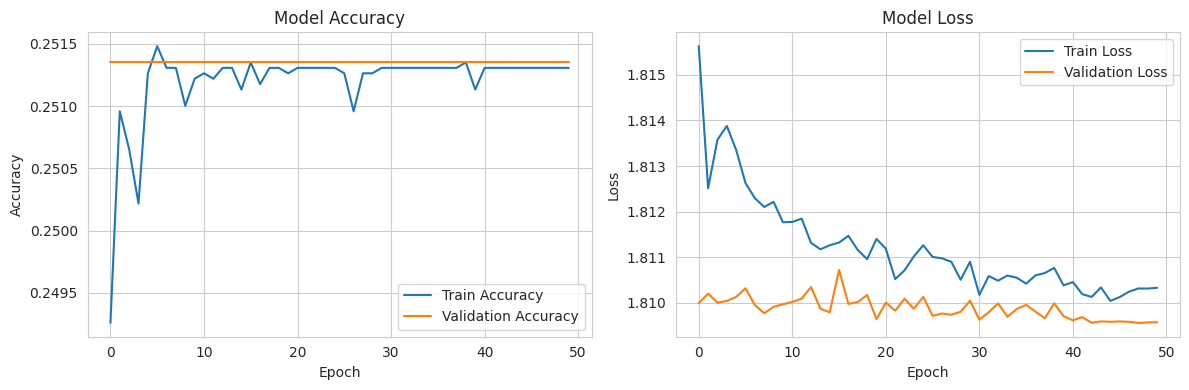

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step


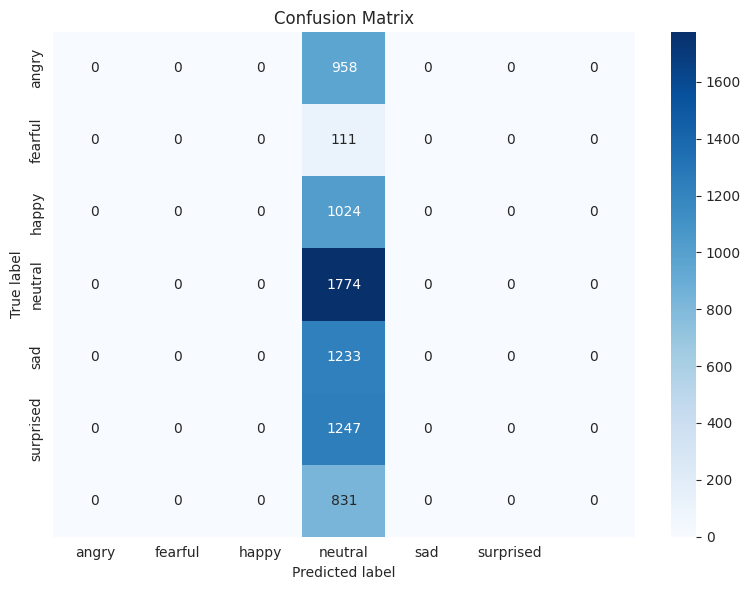

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Nama-nama kelas emosi
class_names = ["angry", "fearful", "happy", "neutral", "sad", "surprised"]

# Peroleh true labels dari test generator
true_labels = test_generator.classes

# Reset test generator sebelum prediksi
test_generator.reset()

# Dapatkan prediksi model pada data test
predicted = model.predict(test_generator)
predicted_labels = np.argmax(predicted, axis=1)

# Hitung confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()

## Using Transfer Learning

### VGGNet

### ResNet

### ImageNet